# ノートブック10: 自動ハイパーパラメータチューニング

## 学習目標

このノートブックでは、機械学習モデルのハイパーパラメータを体系的に最適化する手法を学びます:

1. **ハイパーパラメータとは**
   - モデルパラメータとの違い
   - 重要なハイパーパラメータの理解

2. **GridSearchCV**
   - 網羅的探索の仕組み
   - 計算コストとトレードオフ
   - 結果の分析と可視化

3. **RandomizedSearchCV**
   - 確率的サンプリング
   - 連続分布の活用
   - 大規模パラメータ空間への対応

4. **複数の評価指標**
   - マルチメトリック最適化
   - メトリック間のトレードオフ

5. **実践的な戦略**
   - 段階的チューニング
   - ベストプラクティス
   - 計算効率の向上

---

## セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, loguniform, randint
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV,
    cross_val_score, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
np.random.seed(42)

print("Setup complete!")

Setup complete!


---

## 1. ハイパーパラメータとは

### パラメータ vs ハイパーパラメータ

- **パラメータ**: 訓練中に学習される値 (例: 重み、バイアス)
- **ハイパーパラメータ**: 訓練前に設定する値 (例: 学習率、正則化係数)

### なぜチューニングが重要か

1. モデルの性能を大きく左右
2. 過学習と未学習のバランス
3. 収束速度と安定性

### 主要なハイパーパラメータ

**MLP:**
- `hidden_layer_sizes`: ネットワーク構造
- `alpha`: L2正則化係数
- `learning_rate_init`: 学習率

**Random Forest:**
- `n_estimators`: 木の数
- `max_depth`: 木の深さ
- `min_samples_split`: 分割の最小サンプル数

**SVM:**
- `C`: ペナルティパラメータ
- `gamma`: カーネル係数
- `kernel`: カーネル関数

In [2]:
# データセットの準備
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=15,
    n_redundant=3,
    n_classes=3,
    n_clusters_per_class=2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dataset Information:")
print("="*60)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y_train)}")

Dataset Information:
Training samples: 1600
Test samples: 400
Features: 20
Classes: 3
Class distribution: [536 535 529]


---

## 2. GridSearchCV: 網羅的探索

GridSearchCVは、指定されたパラメータグリッドのすべての組み合わせを試します。

### 利点
- すべての組み合わせを確実に評価
- 再現性が高い
- パラメータ間の相互作用を理解

### 欠点
- 計算コストが高い (組み合わせ爆発)
- パラメータ数が多いと非現実的

In [3]:
# MLPのパラメータグリッド
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

# 組み合わせ数の計算
total_combinations = 1
for param, values in param_grid_mlp.items():
    total_combinations *= len(values)
    print(f"{param}: {len(values)} options")

print(f"\nTotal combinations: {total_combinations}")
print(f"With 5-fold CV: {total_combinations * 5} model fits")

hidden_layer_sizes: 4 options
activation: 2 options
alpha: 3 options
learning_rate_init: 2 options

Total combinations: 48
With 5-fold CV: 240 model fits


In [4]:
# GridSearchCVの実行
mlp = MLPClassifier(
    solver='adam',
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

grid_search = GridSearchCV(
    mlp,
    param_grid_mlp,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("Starting GridSearchCV...")
grid_search.fit(X_train_scaled, y_train)

print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"\nBest CV Score: {grid_search.best_score_:.4f}")
print(f"Test Score: {grid_search.score(X_test_scaled, y_test):.4f}")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

Starting GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits



GRID SEARCH RESULTS

Best CV Score: 0.8944
Test Score: 0.9025

Best Parameters:
  activation: relu
  alpha: 0.01
  hidden_layer_sizes: (100,)
  learning_rate_init: 0.01


### 結果の詳細分析

In [5]:
# 結果をDataFrameに変換
results_df = pd.DataFrame(grid_search.cv_results_)

# Top 10の組み合わせ
cols = ['param_hidden_layer_sizes', 'param_activation', 'param_alpha',
        'param_learning_rate_init', 'mean_test_score', 'std_test_score',
        'mean_train_score', 'rank_test_score']
top_results = results_df[cols].sort_values('rank_test_score')

print("\nTop 10 Parameter Combinations:")
print(top_results.head(10).to_string(index=False))


Top 10 Parameter Combinations:
param_hidden_layer_sizes param_activation  param_alpha  param_learning_rate_init  mean_test_score  std_test_score  mean_train_score  rank_test_score
               (100, 50)             relu       0.0100                      0.01         0.894375        0.014170          0.989687                1
                  (100,)             relu       0.0100                      0.01         0.894375        0.014711          0.978594                1
                  (100,)             relu       0.0001                      0.01         0.893750        0.015934          0.975781                3
                  (100,)             relu       0.0010                      0.01         0.892500        0.015637          0.976094                4
                (50, 25)             relu       0.0001                      0.01         0.891250        0.016226          0.978906                5
               (100, 50)             relu       0.0001                    

### パラメータ効果の可視化

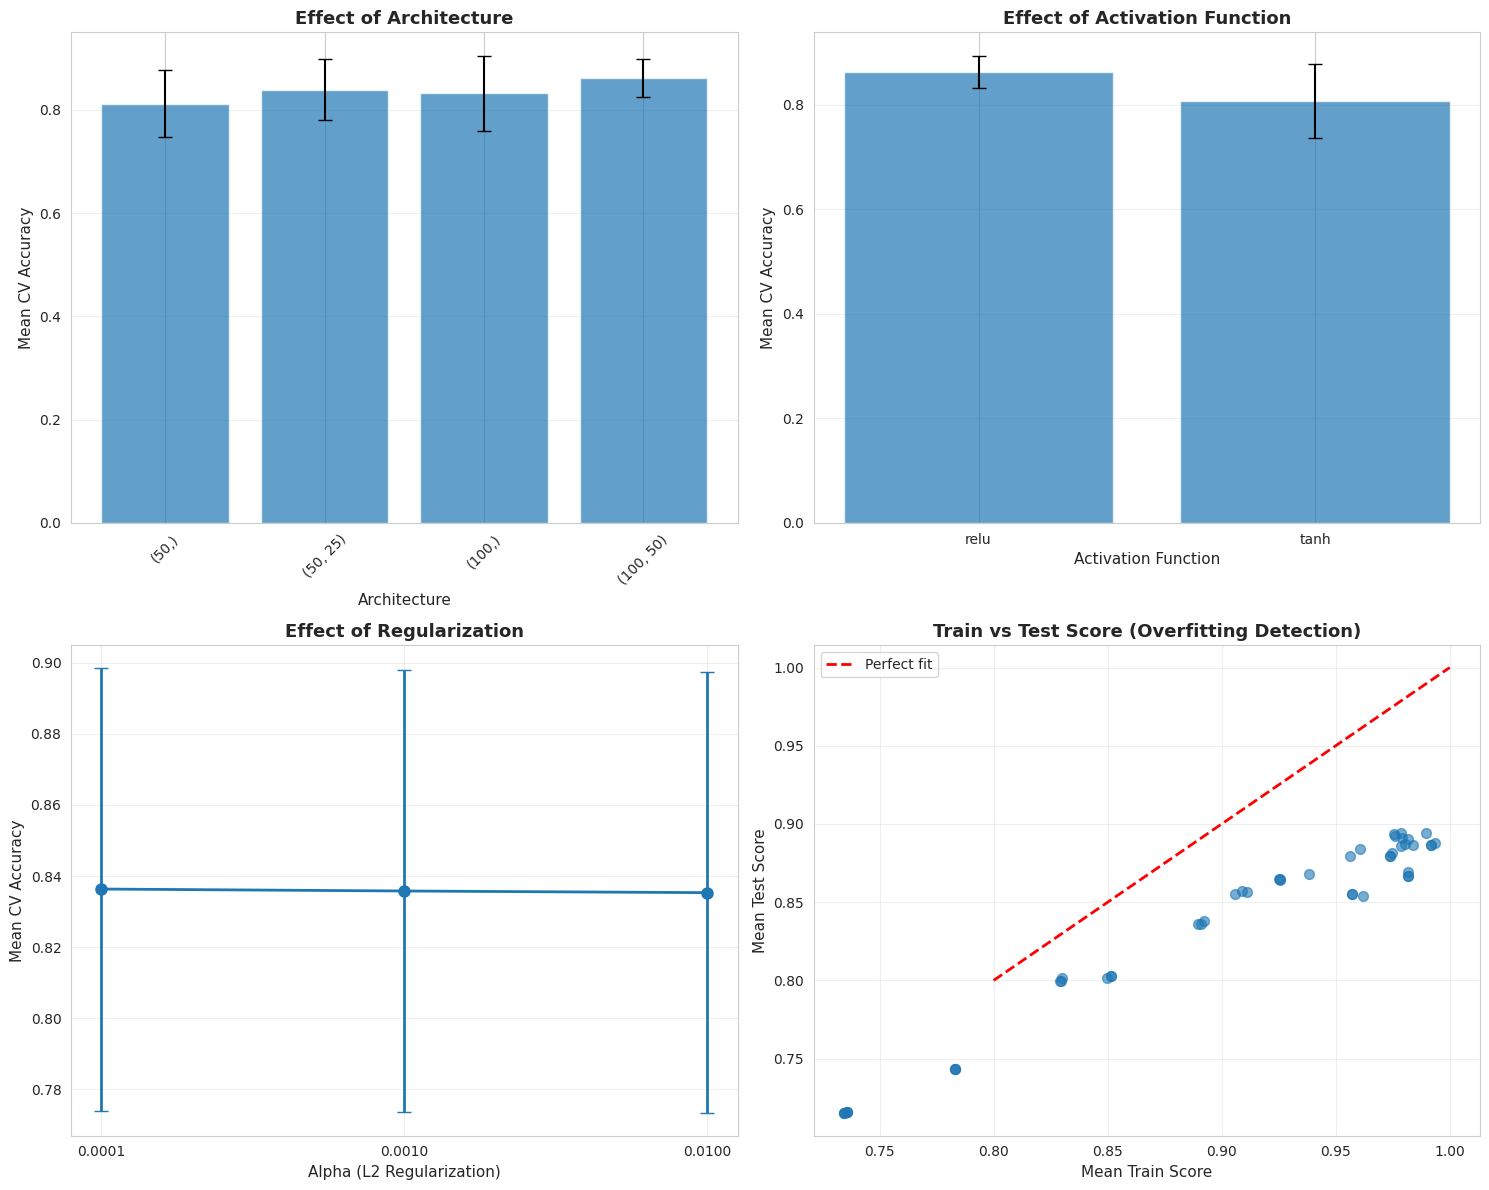


Key Observations:
- Points far from the diagonal line indicate overfitting
- Look for parameters with low variance (more stable)
- Balance between performance and complexity


In [6]:
# GridSearch結果の包括的な可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. アーキテクチャの影響
arch_results = results_df.groupby('param_hidden_layer_sizes')['mean_test_score'].agg(['mean', 'std'])
arch_labels = [str(a) for a in arch_results.index]
axes[0, 0].bar(arch_labels, arch_results['mean'], yerr=arch_results['std'], alpha=0.7, capsize=5)
axes[0, 0].set_xlabel('Architecture', fontsize=11)
axes[0, 0].set_ylabel('Mean CV Accuracy', fontsize=11)
axes[0, 0].set_title('Effect of Architecture', fontsize=13, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. 活性化関数の影響
act_results = results_df.groupby('param_activation')['mean_test_score'].agg(['mean', 'std'])
axes[0, 1].bar(act_results.index, act_results['mean'], yerr=act_results['std'], alpha=0.7, capsize=5)
axes[0, 1].set_xlabel('Activation Function', fontsize=11)
axes[0, 1].set_ylabel('Mean CV Accuracy', fontsize=11)
axes[0, 1].set_title('Effect of Activation Function', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Alphaの影響
alpha_results = results_df.groupby('param_alpha')['mean_test_score'].agg(['mean', 'std'])
axes[1, 0].errorbar(range(len(alpha_results)), alpha_results['mean'],
                    yerr=alpha_results['std'], marker='o', markersize=8, capsize=5, linewidth=2)
axes[1, 0].set_xticks(range(len(alpha_results)))
axes[1, 0].set_xticklabels([f'{a:.4f}' for a in alpha_results.index])
axes[1, 0].set_xlabel('Alpha (L2 Regularization)', fontsize=11)
axes[1, 0].set_ylabel('Mean CV Accuracy', fontsize=11)
axes[1, 0].set_title('Effect of Regularization', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Train vs Test (過学習の検出)
axes[1, 1].scatter(results_df['mean_train_score'], results_df['mean_test_score'], 
                   alpha=0.6, s=50)
axes[1, 1].plot([0.8, 1], [0.8, 1], 'r--', lw=2, label='Perfect fit')
axes[1, 1].set_xlabel('Mean Train Score', fontsize=11)
axes[1, 1].set_ylabel('Mean Test Score', fontsize=11)
axes[1, 1].set_title('Train vs Test Score (Overfitting Detection)', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Points far from the diagonal line indicate overfitting")
print("- Look for parameters with low variance (more stable)")
print("- Balance between performance and complexity")

---

## 3. RandomizedSearchCV: 効率的な探索

大規模なパラメータ空間では、RandomizedSearchCVが効率的です。

### 利点
- 連続分布からサンプリング可能
- 計算時間を制御しやすい
- 意外な良い組み合わせを発見できる

### 確率分布の活用
- `uniform(a, b)`: 一様分布
- `loguniform(a, b)`: 対数一様分布 (学習率などに適切)
- `randint(a, b)`: 整数の一様分布

In [7]:
# 連続分布を使ったパラメータ定義
param_distributions = {
    'hidden_layer_sizes': [
        (50,), (100,), (200,),
        (50, 25), (100, 50), (200, 100),
        (100, 50, 25), (200, 100, 50)
    ],
    'activation': ['relu', 'tanh'],
    'alpha': loguniform(1e-5, 1e-1),  # 対数スケール
    'learning_rate_init': loguniform(1e-4, 1e-1),
    'batch_size': [32, 64, 128, 256]
}

print("Parameter Distributions:")
print("="*60)
for param, dist in param_distributions.items():
    if isinstance(dist, list):
        print(f"{param}: {len(dist)} discrete options")
    else:
        print(f"{param}: Continuous distribution")

Parameter Distributions:
hidden_layer_sizes: 8 discrete options
activation: 2 discrete options
alpha: Continuous distribution
learning_rate_init: Continuous distribution
batch_size: 4 discrete options


In [8]:
# RandomizedSearchCVの実行
mlp_random = MLPClassifier(
    solver='adam',
    max_iter=500,
    early_stopping=True,
    random_state=42
)

random_search = RandomizedSearchCV(
    mlp_random,
    param_distributions,
    n_iter=50,  # サンプル数
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

print("Starting RandomizedSearchCV (50 iterations)...")
random_search.fit(X_train_scaled, y_train)

print("\n" + "="*60)
print("RANDOMIZED SEARCH RESULTS")
print("="*60)
print(f"\nBest CV Score: {random_search.best_score_:.4f}")
print(f"Test Score: {random_search.score(X_test_scaled, y_test):.4f}")
print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.6f}")
    else:
        print(f"  {param}: {value}")

Starting RandomizedSearchCV (50 iterations)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits



RANDOMIZED SEARCH RESULTS

Best CV Score: 0.8906
Test Score: 0.8875

Best Parameters:
  activation: tanh
  alpha: 0.000097
  batch_size: 128
  hidden_layer_sizes: (100,)
  learning_rate_init: 0.013703


### RandomizedSearchの探索パターン

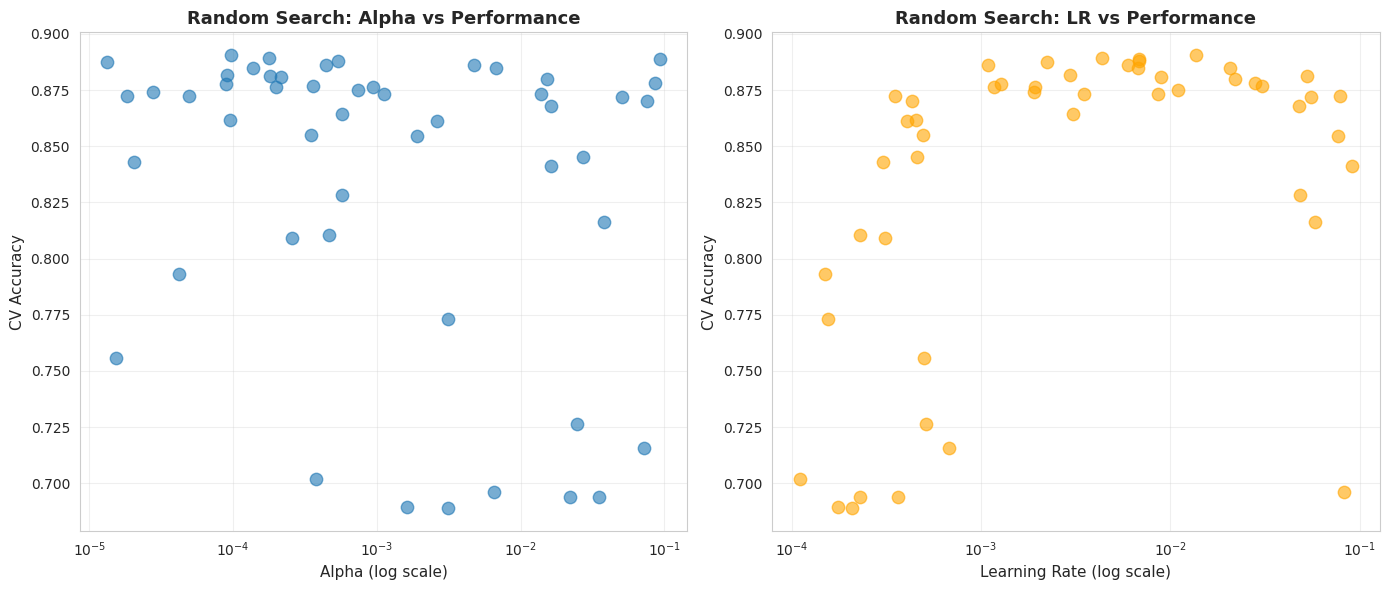


Observations:
- Wide exploration of parameter space
- Log-uniform sampling for learning rate and alpha
- Can find good regions efficiently


In [9]:
# サンプリングされたパラメータの分布
random_results = pd.DataFrame(random_search.cv_results_)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Alpha のサンプリング分布
axes[0].scatter(random_results['param_alpha'], random_results['mean_test_score'], 
                alpha=0.6, s=80)
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha (log scale)', fontsize=11)
axes[0].set_ylabel('CV Accuracy', fontsize=11)
axes[0].set_title('Random Search: Alpha vs Performance', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Learning Rate のサンプリング分布
axes[1].scatter(random_results['param_learning_rate_init'], random_results['mean_test_score'],
                alpha=0.6, s=80, color='orange')
axes[1].set_xscale('log')
axes[1].set_xlabel('Learning Rate (log scale)', fontsize=11)
axes[1].set_ylabel('CV Accuracy', fontsize=11)
axes[1].set_title('Random Search: LR vs Performance', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Wide exploration of parameter space")
print("- Log-uniform sampling for learning rate and alpha")
print("- Can find good regions efficiently")

---

## 4. 複数モデルのチューニング

異なるモデルで最適なハイパーパラメータを探索します。

In [10]:
# Random Forestのチューニング
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Tuning Random Forest...")
rf_search.fit(X_train_scaled, y_train)

print(f"\nRandom Forest Best CV Score: {rf_search.best_score_:.4f}")
print(f"Test Score: {rf_search.score(X_test_scaled, y_test):.4f}")
print(f"\nBest Parameters:")
for param, value in rf_search.best_params_.items():
    print(f"  {param}: {value}")

Tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits



Random Forest Best CV Score: 0.8400
Test Score: 0.8775

Best Parameters:
  max_depth: 20
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200


In [11]:
# SVMのチューニング
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'poly']
}

svm_search = GridSearchCV(
    SVC(random_state=42),
    svm_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nTuning SVM...")
svm_search.fit(X_train_scaled, y_train)

print(f"\nSVM Best CV Score: {svm_search.best_score_:.4f}")
print(f"Test Score: {svm_search.score(X_test_scaled, y_test):.4f}")
print(f"\nBest Parameters:")
for param, value in svm_search.best_params_.items():
    print(f"  {param}: {value}")


Tuning SVM...
Fitting 5 folds for each of 40 candidates, totalling 200 fits



SVM Best CV Score: 0.9144
Test Score: 0.9175

Best Parameters:
  C: 1
  gamma: 0.1
  kernel: rbf


### チューニング済みモデルの比較


Tuned Model Comparison:
        Model  CV Mean   CV Std  Test Score
          SVM 0.914375 0.022930      0.9175
   MLP (Grid) 0.894375 0.014711      0.9025
 MLP (Random) 0.890625 0.014790      0.8875
Random Forest 0.840000 0.011592      0.8775


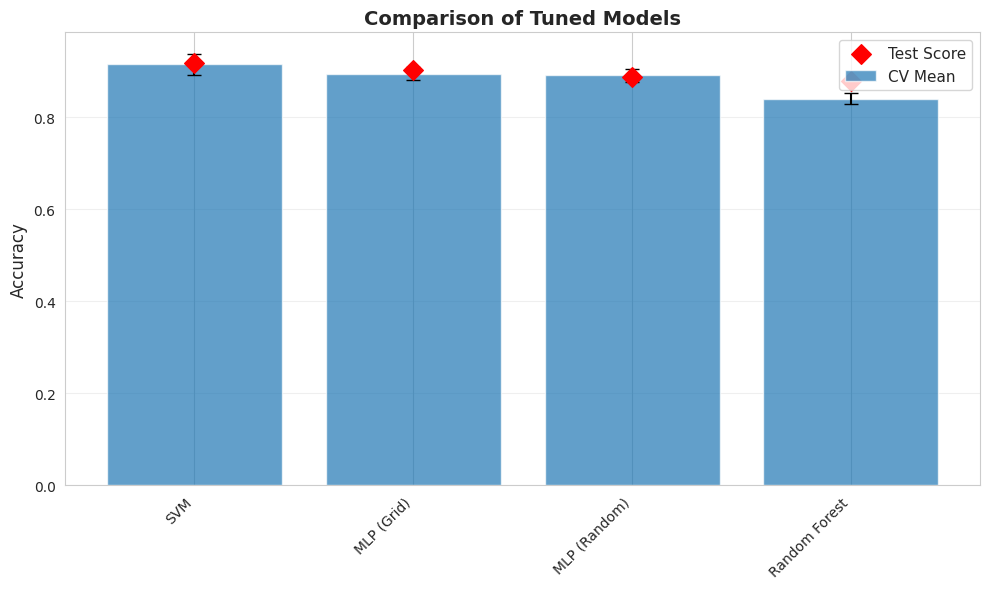

In [12]:
# すべてのチューニング済みモデルを比較
tuned_models = {
    'MLP (Grid)': grid_search.best_estimator_,
    'MLP (Random)': random_search.best_estimator_,
    'Random Forest': rf_search.best_estimator_,
    'SVM': svm_search.best_estimator_
}

comparison_results = []

for name, model in tuned_models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    test_score = model.score(X_test_scaled, y_test)
    
    comparison_results.append({
        'Model': name,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Test Score': test_score
    })

df_comparison = pd.DataFrame(comparison_results).sort_values('Test Score', ascending=False)

print("\nTuned Model Comparison:")
print("="*60)
print(df_comparison.to_string(index=False))

# 可視化
plt.figure(figsize=(10, 6))
x = np.arange(len(df_comparison))
plt.bar(x, df_comparison['CV Mean'], yerr=df_comparison['CV Std'], 
        alpha=0.7, capsize=5, label='CV Mean')
plt.scatter(x, df_comparison['Test Score'], color='red', s=100, 
            zorder=5, label='Test Score', marker='D')
plt.xticks(x, df_comparison['Model'], rotation=45, ha='right')
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Tuned Models', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

---

## 5. マルチメトリック最適化

複数の評価指標を同時に考慮します。

In [13]:
# 複数の評価指標を定義
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro'
}

param_grid_multi = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01]
}

mlp_multi = MLPClassifier(
    activation='relu',
    solver='adam',
    max_iter=500,
    early_stopping=True,
    random_state=42
)

multi_search = GridSearchCV(
    mlp_multi,
    param_grid_multi,
    cv=5,
    scoring=scoring,
    refit='f1',  # F1スコアで最良モデルを選択
    n_jobs=-1,
    return_train_score=True
)

print("Running multi-metric search...")
multi_search.fit(X_train_scaled, y_train)

print("\nMulti-metric Results:")
print("="*60)

multi_results = pd.DataFrame(multi_search.cv_results_)
for metric in scoring.keys():
    best_idx = multi_results[f'mean_test_{metric}'].idxmax()
    best_score = multi_results.loc[best_idx, f'mean_test_{metric}']  
    best_params = multi_results.loc[best_idx, 'params']
    print(f"\nBest {metric.upper()}:")
    print(f"  Score: {best_score:.4f}")
    print(f"  Parameters: {best_params}")

Running multi-metric search...



Multi-metric Results:

Best ACCURACY:
  Score: 0.8650
  Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)}

Best PRECISION:
  Score: 0.8656
  Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)}

Best RECALL:
  Score: 0.8649
  Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)}

Best F1:
  Score: 0.8645
  Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)}


---

## 6. 実践的なチューニング戦略

### 段階的アプローチ

In [14]:
print("Hyperparameter Tuning Strategy:")
print("="*60)
print()
print("PHASE 1: COARSE SEARCH")
print("  • Wide parameter ranges")
print("  • Few CV folds (3-fold)")
print("  • Identify promising regions")
print("  • Example: alpha in [0.0001, 0.01, 1]")
print()
print("PHASE 2: REFINED SEARCH")
print("  • Narrow ranges around best values")
print("  • More CV folds (5-fold)")
print("  • Denser grid")
print("  • Example: alpha in [0.001, 0.005, 0.01, 0.05]")
print()
print("PHASE 3: FINE-TUNING")
print("  • Very narrow ranges")
print("  • Full CV (10-fold)")
print("  • Final optimization")
print()
print("BEST PRACTICES:")
print("  ✓ Start simple, increase complexity")
print("  ✓ Use RandomizedSearchCV for initial exploration")
print("  ✓ GridSearchCV for final refinement")
print("  ✓ Monitor train/test gap for overfitting")
print("  ✓ Use log-uniform for learning rates")
print("  ✓ Consider computational budget")
print("  ✓ Document all experiments")

Hyperparameter Tuning Strategy:

PHASE 1: COARSE SEARCH
  • Wide parameter ranges
  • Few CV folds (3-fold)
  • Identify promising regions
  • Example: alpha in [0.0001, 0.01, 1]

PHASE 2: REFINED SEARCH
  • Narrow ranges around best values
  • More CV folds (5-fold)
  • Denser grid
  • Example: alpha in [0.001, 0.005, 0.01, 0.05]

PHASE 3: FINE-TUNING
  • Very narrow ranges
  • Full CV (10-fold)
  • Final optimization

BEST PRACTICES:
  ✓ Start simple, increase complexity
  ✓ Use RandomizedSearchCV for initial exploration
  ✓ GridSearchCV for final refinement
  ✓ Monitor train/test gap for overfitting
  ✓ Use log-uniform for learning rates
  ✓ Consider computational budget
  ✓ Document all experiments


---

## まとめ

### ハイパーパラメータチューニングの要点

1. **GridSearchCV**
   - すべての組み合わせを試す
   - 小規模パラメータ空間に最適
   - 再現性が高い

2. **RandomizedSearchCV**
   - 確率的サンプリング
   - 大規模空間に効率的
   - 連続分布を活用

3. **戦略**
   - 粗い探索 → 精密化
   - Random → Grid
   - 計算コストを考慮

4. **評価**
   - 複数の指標を確認
   - 過学習に注意
   - クロスバリデーションが必須

### 重要なポイント

- **ドメイン知識**: パラメータの意味を理解する
- **計算効率**: `n_jobs=-1`で並列化
- **再現性**: `random_state`を固定
- **文書化**: 実験を記録する

---

**次のステップ**: ノートブック11で、複数のモデルを体系的に比較し、最適なモデルを選択します!
